<hr>
<br><br><br>
<div align=center>
<font size=2>
        Trabalho de Conclusão de Curso
    </font>
    <br><br><BR>
    <font size=3>
        Classificação de sentimento em arquivos de áudio<br>a partir da extração de Coeficientes Cepstrais na frequência Mel<br>(MFCCs)
    </font>
    <br><br><BR>
    <font size=2>
        ICMC-USP
    </font>    
</div>
<br><br><br>
<hr>

<br><br>
<a id=menu></a>

[Biblotecas](#libs) <br>
[Dados](#data) <br>
[Pré-processamento](#prep) <br>
[Processamento](#proc) <br>
[Avaliação](#aval) <br>

<br>

<a id='libs'></a>
###<h3>Bibliotecas</h3>
<br>
<blockquote>
    <dl>
        <dl>- keras: interface para desenvolvimento de redes neurais.</dl>
        <dl>- librosa: múltiplas funcionalidades para tratamento de arquivos de áudio.</dl>
        <dl>- Matplotlib: criação de gráficos e visuadlzação de dados.</dl>
        <dl>- Numpy: processamento de vetores e matrizes multimensionais.</dl>
        <dl>- Pandas: manipulação e análise de dados tabulares e séries temporais</dl>
        <dl>- Seaborn: criação de gráficos e visualização de dados.</dl>
        <dl>- Sklearn: algoritmos de aprendizado de máquina.</dl>
        <dl>- TensorFlow: desenho de fluxos e processamento de tensores para aprendizado de máquina.</dl>
    </dl>
</blockquote>


In [ ]:
import numpy as np 
import pandas as pd 

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
f1_score, log_loss, cohen_kappa_score, roc_auc_score)
from imblearn.metrics import geometric_mean_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns

from numpy.random import seed
from tensorflow.random import set_seed

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Conv1D, Conv2D, Dense, Dropout, Flatten, Input, LSTM, MaxPooling2D 
from tensorflow import keras

import time


<a id='proc'></a>
### <h3>Dados</h3>

<font size=1>[menu](#menu)</font>

In [ ]:
folder_path = '../data/'
file_name = 'voice_features_raw_40.csv'
df = pd.read_csv(folder_path + file_name)
print(df.shape)

(1440, 290)


In [ ]:
### Remove neutral emotion tuples as recommended by ravdess publishers

df = df[df.emotion!='neutral']
print(df.shape)
df.head(2)

(1344, 290)


,MEL_0,MEL_1,MEL_2,MEL_3,MEL_4,MEL_5,MEL_6,MEL_7,MEL_8,MEL_9,MEL_10,MEL_11,MEL_12,MEL_13,MEL_14,MEL_15,MEL_16,MEL_17,MEL_18,MEL_19,MEL_20,MEL_21,MEL_22,MEL_23,MEL_24,MEL_25,MEL_26,MEL_27,MEL_28,MEL_29,MEL_30,MEL_31,MEL_32,MEL_33,MEL_34,MEL_35,MEL_36,MEL_37,MEL_38,MEL_39,...,PNCC_2,PNCC_3,PNCC_4,PNCC_5,PNCC_6,PNCC_7,PNCC_8,PNCC_9,PNCC_10,PNCC_11,PNCC_12,PNCC_13,PNCC_14,PNCC_15,PNCC_16,PNCC_17,PNCC_18,PNCC_19,PNCC_20,PNCC_21,PNCC_22,PNCC_23,PNCC_24,PNCC_25,PNCC_26,PNCC_27,PNCC_28,PNCC_29,PNCC_30,PNCC_31,PNCC_32,PNCC_33,PNCC_34,PNCC_35,PNCC_36,PNCC_37,PNCC_38,PNCC_39,emotion,actor
1,0.000013,0.000555,0.009175,0.020292,0.018322,0.006961,0.013214,0.015581,0.016653,0.013299,0.004880,0.005009,0.009620,0.019270,0.014089,0.002810,0.002958,0.008433,0.005448,0.000935,0.001446,0.004113,0.002633,0.000371,0.000264,0.000293,0.000107,0.000083,0.000176,0.000178,0.000349,0.000179,0.000137,0.000242,0.000957,0.001207,0.000271,0.000193,0.000659,0.000289,...,1.112999e-15,-1.565414e-16,-4.342591e-17,-7.081141e-17,1.091719e-16,-1.194646e-17,8.420926e-17,1.039678e-17,-4.801715e-17,1.678634e-17,8.211024e-19,1.658396e-17,-1.601728e-17,4.255855e-18,1.233967e-17,2.775558e-17,-7.355228e-18,-3.885781e-18,6.846375e-18,1.156482e-17,-1.639892e-17,-5.701458e-18,-2.645453e-18,-1.934217e-18,6.924438e-19,5.611830e-18,-4.475587e-18,-1.725616e-17,-1.747445e-17,-3.006854e-19,-1.001514e-17,1.554023e-17,-2.740863e-17,-1.116005e-18,1.503427e-19,-3.920475e-18,-4.377286e-17,1.356265e-17,calm,Actor_01
3,0.000019,0.002271,0.016217,0.018024,0.022248,0.010594,0.008520,0.006765,0.013506,0.017910,0.005543,0.003556,0.006492,0.015117,0.026937,0.011562,0.004729,0.001525,0.004829,0.008202,0.002394,0.001630,0.003089,0.003037,0.000795,0.000218,0.000097,0.000173,0.000314,0.000339,0.000545,0.000550,0.000329,0.000554,0.001086,0.000789,0.000368,0.000401,0.000178,0.000251,...,1.409798e-15,2.046511e-16,-6.226501e-17,8.234154e-18,5.588123e-17,5.153285e-17,5.819419e-17,5.241178e-17,1.767105e-17,9.483155e-19,3.249715e-17,-1.262879e-17,4.772803e-17,-3.727343e-17,-3.402371e-17,-6.383782e-18,7.864080e-19,2.885423e-18,-2.347659e-18,-1.748601e-17,-8.766136e-18,1.541591e-17,2.562765e-17,1.484923e-17,-1.440977e-17,-1.827242e-18,9.043692e-18,1.299886e-17,2.279427e-17,-3.885781e-18,4.695318e-18,-8.615793e-18,4.625929e-19,3.660267e-18,9.830100e-19,-2.700386e-18,-5.863365e-18,9.110189e-18,calm,Actor_01


In [ ]:
features_name = ['MEL','CHROMA','MFCC','GFCC','PNCC']
features_interval = [(0,128),(128,168),(168,208),(208,248),(248,288)]


In [ ]:
def split_data_by_feature(data: pd.DataFrame, features_interval: list) -> dict:
    data_dict = {}
    for idx, interval in enumerate(features_interval):
      data_dict[features_name[idx]] = data.iloc[:,interval[0]:interval[1]]
    
    return data_dict


In [ ]:
features_dict = split_data_by_feature(df, features_interval)
features_dict.keys()

dict_keys(['MEL', 'CHROMA', 'MFCC', 'GFCC', 'PNCC'])


<a id='proc'></a>
### <h3>Processamento</h3>

<font size=1>[menu](#menu)</font>

In [ ]:

target = df.emotion.values

ft = 'MEL'
X = features_dict[ft]

le = LabelEncoder()
le.fit(target)
y = le.transform(target)

print(X.shape)
print(y.shape)

(1344, 128)
(1344,)


In [ ]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    stratify=y, random_state=42)


In [ ]:
print(X_train.shape)
print(X_test.shape)

(1075, 128)
(269, 128)


In [ ]:
### Normalize data

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


#### Training

In [ ]:
from tensorflow.keras.utils import to_categorical
print(y_train[:3])
y_train = to_categorical(y_train,7)
print(y_train[:3])
y_test = to_categorical(y_test,7)

[3 5 3]
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


In [ ]:
def get_model(input_shape, num_classes):
    
    input = Input(shape=(input_shape,1,), name='input_layer')
    x1 = LSTM(13, activation='relu', return_sequences=True, name='layer_1_lstm')(input)
    x2 = Dropout(.1, name='layer_2_dropout')(x1)
    x3 = LSTM(39, activation='relu', return_sequences=True, name='layer_3_lstm')(x2)
    x4 = Dropout(.3, name='layer_4_dropout')(x3)
    x5 = LSTM(13, activation='relu', name='layer_5_lstm')(x4)
    x6 = Dropout(.1, name='layer_6_dropout')(x5)
    # x7 = Dense(98, activation='relu', name='layer_7_dense')(x6)
    # x8 = Dropout(.1, name='layer_5_dropout')(x7)
    out = Dense(7, activation='softmax', name='output_layer')(x6)

    model = Model(input, out)

    return model

In [ ]:
def compileModel(model):
  seed(1)
  set_seed(2)
  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=.005),
                metrics=['Accuracy','Precision','Recall','AUC'])


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.math import exp

def trainModel(model):
  epochs=50
  batch_size=128

  # função de decaimento para a taxa de aprendizado
  def scheduler(epoch, lr):
      return np.clip(lr * exp(-.005), 0.00001, 0.001)

  learningRate_cb = LearningRateScheduler(scheduler)
  earlyStopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
  mdlCheckpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5',
                                              monitor="val_Accuracy", save_best_only=True) 

  hist = model.fit(X_train, y_train, validation_split=.2, 
                      callbacks=[learningRate_cb,earlyStopping_cb,mdlCheckpoint_cb],
                      batch_size=batch_size, epochs=epochs, verbose=0)
  return hist


#### Cross Validation Training

In [ ]:
from sklearn.model_selection import KFold

auc_per_fold, acc_per_fold, loss_per_fold, modelHist, modelRes = [], [], [], [], []

num_folds = 10
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X_train, y_train):
    
  start = time.time()

  # Define the model architecture
  model = get_model(X_train.shape[1],7)

  # Compile the model
  compileModel(model)

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  hist = trainModel(model)

  # Generate generalization metrics
  scores = model.evaluate(X_train[test], y_train[test], verbose=0)
  auc = roc_auc_score(y_train[test], model.predict(X_train[test]), multi_class='ovr')

  print(f'\t{model.metrics_names[0]}: {round(scores[0],2)}\
   \n\t{model.metrics_names[1]}: {round(scores[1],2)}\n\tAUC: {round(auc,2)}')
  auc_per_fold.append(round(auc,2))
  acc_per_fold.append(round(scores[1],2))
  loss_per_fold.append(round(scores[0],2))
  modelHist.append(hist)
  modelRes.append(model)

  # Increase fold number
  fold_no = fold_no + 1

  runtime = time.time() - start
  print(f"\nFinished in {runtime:.2f} seconds.\n")

------------------------------------------------------------------------
Training for fold 1 ...
	loss: 1.95   
	Accuracy: 0.14
	AUC: 0.63

Finished in 84.64 seconds.

------------------------------------------------------------------------
Training for fold 2 ...
	loss: 1.94   
	Accuracy: 0.21
	AUC: 0.57

Finished in 90.53 seconds.

------------------------------------------------------------------------
Training for fold 3 ...
	loss: 1.94   
	Accuracy: 0.19
	AUC: 0.62

Finished in 149.55 seconds.

------------------------------------------------------------------------
Training for fold 4 ...
	loss: 1.77   
	Accuracy: 0.29
	AUC: 0.68

Finished in 272.60 seconds.

------------------------------------------------------------------------
Training for fold 5 ...
	loss: 2.1   
	Accuracy: 0.22
	AUC: 0.61

Finished in 71.46 seconds.

------------------------------------------------------------------------
Training for fold 6 ...
	loss: 2.06   
	Accuracy: 0.15
	AUC: 0.63

Finished in 147.54 

In [ ]:
results_cv = {'auc':auc_per_fold,
              'loss':loss_per_fold,
              'acc':auc_per_fold,
              'hist':modelHist,
              'model':modelRes}
cv = pd.DataFrame(results_cv).sort_values(by=['auc','loss','acc'],ascending=[False,True,False])
round(cv,2)

,auc,loss,acc,hist,model
3,0.68,1.77,0.68,<keras.callbacks.History object at 0x7efacc40e...,<keras.engine.functional.Functional object at ...
9,0.68,1.90,0.68,<keras.callbacks.History object at 0x7efac55b1...,<keras.engine.functional.Functional object at ...
0,0.63,1.95,0.63,<keras.callbacks.History object at 0x7efacc23c...,<keras.engine.functional.Functional object at ...
5,0.63,2.06,0.63,<keras.callbacks.History object at 0x7efac8ff1...,<keras.engine.functional.Functional object at ...
2,0.62,1.94,0.62,<keras.callbacks.History object at 0x7efacabf5...,<keras.engine.functional.Functional object at ...
4,0.61,2.10,0.61,<keras.callbacks.History object at 0x7efac9a6b...,<keras.engine.functional.Functional object at ...
8,0.61,8.38,0.61,<keras.callbacks.History object at 0x7efac727a...,<keras.engine.functional.Functional object at ...
6,0.60,1.94,0.60,<keras.callbacks.History object at 0x7efac8b65...,<keras.engine.functional.Functional object at ...
7,0.60,1.94,0.60,<keras.callbacks.History object at 0x7efac75e9...,<keras.engine.functional.Functional object at ...
1,0.57,1.94,0.57,<keras.callbacks.History object at 0x7efacbedb...,<keras.engine.functional.Functional object at ...


In [ ]:
clf_best = cv.loc[9,'model']

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# print prediction results
predictions = clf_best.predict(X_test)
predictions = [np.argmax(y) for y in predictions]
y_classes = [np.argmax(y) for y in y_test]

print(f'\t\t\tLSTM / {ft} REPORT\n')
print(classification_report(y_classes, predictions))

			LSTM / MEL REPORT

              precision    recall  f1-score   support

           0       0.29      0.79      0.43        38
           1       0.00      0.00      0.00        38
           2       0.03      0.03      0.03        38
           3       0.00      0.00      0.00        39
           4       0.12      0.41      0.19        39
           5       0.00      0.00      0.00        38
           6       0.00      0.00      0.00        39

    accuracy                           0.17       269
   macro avg       0.06      0.18      0.09       269
weighted avg       0.06      0.17      0.09       269



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:

from sklearn.metrics import roc_auc_score
predictions_prob = clf_best.predict(X_test)

auc = roc_auc_score(y_test, predictions_prob, multi_class='ovr')
print(f'AUC: {round(auc,2)}')

AUC: 0.68


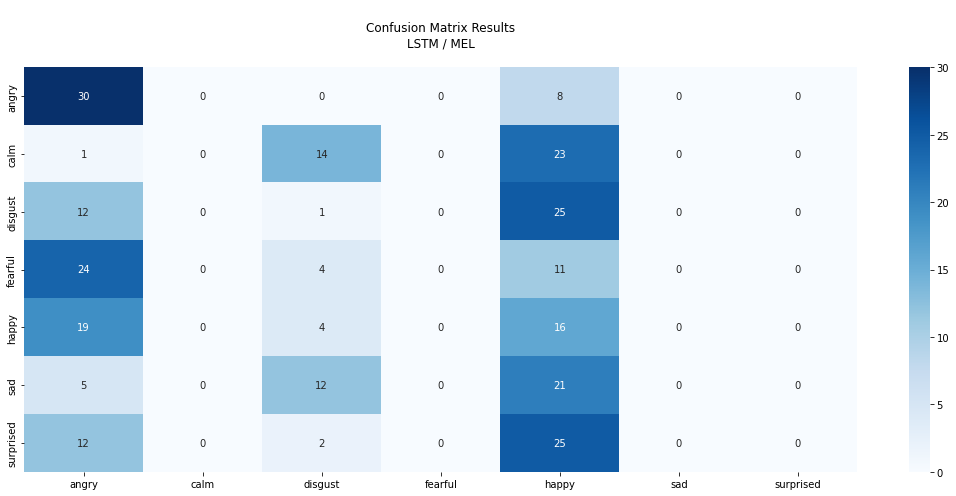

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = clf_best.predict(X_test)
y_pred = [np.argmax(y) for y in y_pred]
y_test_r = [np.argmax(y) for y in y_test]

y_pred_r = le.inverse_transform(y_pred)
y_test_r = le.inverse_transform(y_test_r)

cm = confusion_matrix(y_test_r, y_pred_r, labels=le.classes_)
plt.figure(figsize = (15,7))
plt.title(f'\nConfusion Matrix Results\nLSTM / {ft}\n', size=12)

sns.heatmap(cm, cmap="Blues", annot=True,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.tight_layout()
plt.savefig(f'/content/drive/MyDrive/MBA/TCC/lstm-{ft.lower()}-cm.png', dpi=300)


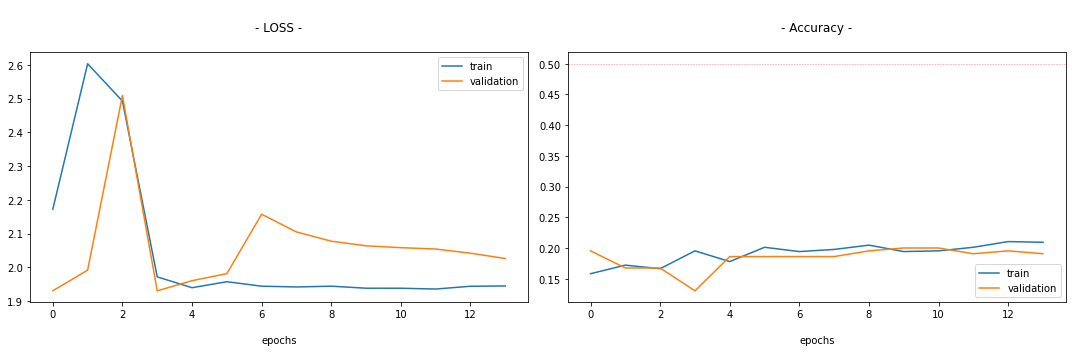

In [ ]:
hist = cv.loc[5,'hist']
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(15,5))
# chart 1
ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('\nepochs')
ax[0].set_title('\n- LOSS -\n')
# chart 2    
ax[1].plot(hist.history['Accuracy'])
ax[1].plot(hist.history['val_Accuracy'])
ax[1].axhline(y=.5, c="#fa8787", linewidth=0.5, ls='dashed')
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('\nepochs')
ax[1].set_title('\n- Accuracy -\n')

plt.tight_layout()

<hr>
<br><br>
<div align=right>
    <font size=2>
        Julio Valim &emsp;
    </font>
    <br>
    <font size=1>
        <a href='https://www.linkedin.com/in/juliovalim'>contato /in</a>&emsp;&emsp;
    </font>
</div>

### Review
OVR <br>
Multiclass ROC

In [1]:
n_classes = 7
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

In [ ]:

plt.figure(figsize=(15,8))
# Plot all ROC curves
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue","mediumseagreen",
                "orchid","tomato","goldenrod"])
line_width = 2
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=line_width,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=line_width)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()